In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os,sys
from lgan.diffeomorphism import tf_diffeomorphism
from tqdm import tqdm
from scipy import misc
from keras.preprocessing import image
from scipy import ndimage, misc
import copy

Using TensorFlow backend.


In [2]:
#hyper-parameter
data_size = 202599
batch_size = 32 #batch size
input_dim = 128 #dim x and z input_size
imX= 28
imY= 28
image_size = imX*imY
LAMBDA = 10
output_dim = imX*imY

#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


In [3]:


#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
#simple plot function
def plot(samples, labels,y,x):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(y, x)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig


#images plotted while learning
def preprocessPlotImages(samples):
    images = np.zeros((batch_size,imY,imX,3))
    for i in range(batch_size):
        befor = copy.copy(samples[1][i])
        after = copy.copy(samples[0][i])
        befor_reshape = misc.imresize(befor, (20,20))/255
        after[44:64,44:64]=befor_reshape
        images[i]=after
    return images
        
        
        
    

In [5]:
'''
#try Diffeomorphism
image = numberImages
image = np.reshape(image, (10,28,28,1))
print(image.shape)
session = tf.InteractiveSession()
diff_map =  np.random.uniform(-0.5,0.3, size=(10,3, 3, 2)) #batch_size, diff_height, diff_width, 2
dif_image = tf_diffeomorphism(image,diff_map)
plot(image,np.zeros(10))
div_image = dif_image.eval()
plot(div_image,np.ones(10))
'''

'\n#try Diffeomorphism\nimage = numberImages\nimage = np.reshape(image, (10,28,28,1))\nprint(image.shape)\nsession = tf.InteractiveSession()\ndiff_map =  np.random.uniform(-0.5,0.3, size=(10,3, 3, 2)) #batch_size, diff_height, diff_width, 2\ndif_image = tf_diffeomorphism(image,diff_map)\nplot(image,np.zeros(10))\ndiv_image = dif_image.eval()\nplot(div_image,np.ones(10))\n'

In [6]:
#get Mean Image for Dif Input
def getMeanImage(batch_size,label):
    images = np.zeros((batch_size,784))
    for i in range(batch_size):      
        l = np.argwhere(label[i]==1)
        index = l[0][0]
        images[i]= np.reshape(numberImages[index],784)
    return images

In [7]:
#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,10)) 
    for i in range(batch_size):
        vector = np.random.uniform(-1., 1., size=[input_dim]) #create noise vector of 100
        index = int(np.random.rand(1)*10)
        labels[i][index]= 1  #get random label 
        batch[i] = vector
    return (batch, labels)

In [8]:
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def resnet_block(inputs, maps=64, kernel=[3, 3],stride=1):
    layer = slim.conv2d(inputs, maps, kernel, stride,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  padding = 'SAME',activation_fn=None)
    layer = slim.batch_norm(layer)
    layer = tf.nn.relu(layer)
    layer = slim.conv2d(layer, maps, kernel, stride,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  padding = 'SAME',activation_fn=None)
    layer = slim.batch_norm(layer)
    outputs = tf.add(inputs, layer)
    return outputs

In [9]:
def simGenerator(image,noise):
    noise = slim.fully_connected(noise, image_size,weights_initializer=tf.truncated_normal_initializer(stddev=0.01))
    noise = tf.reshape(noise, [-1,imY,imX,1])
    image = tf.reshape(image,[batch_size,imY,imX,1])
    net = slim.conv2d(image, 27, [3,3],1)
    net = tf.concat([net, noise],3)
    net = resnet_block(net, maps=28, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=28, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=28, kernel=[3, 3],stride=1)
    net = slim.conv2d(net, 1, [1,1],1)
    return tf.nn.tanh(net)


#Generator - predict parameters for Diffeomorphism
def generator_dif_paras(noise_vector):
    params = tf.reshape(noise_vector,[batch_size,8,8,2])
    params = slim.conv2d(params, 32, [3,3],2,padding="SAME")
    params = slim.conv2d(params, 2, [3,3],2,padding="SAME")
    params = tf.nn.tanh(params)
    params= tf.reshape(params, [batch_size,2,2,2]) 
    return params
    
#Main Generator
def generator(z,class_z,mean_image):
    with tf.variable_scope('generator'):
        mean_image = tf.reshape(mean_image,[batch_size, 28,28,1])
        class_z = slim.fully_connected(class_z, input_dim,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        class_z = tf.nn.relu(class_z)
        class_z = tf.nn.relu(z)
        noise = tf.add(z,class_z)
        
        dif_params = generator_dif_paras(noise)
        dif_image = tf_diffeomorphism(mean_image,dif_params) 
        detailed_image = simGenerator(dif_image,noise)
        return [detailed_image, dif_image]



In [10]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[batch_size,imY,imX,1])
        x = slim.conv2d(x, 16, [4, 4],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        x = leakyReLU(x)
        net = slim.conv2d(x, 32, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 128, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 256, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)     
        return [net,tf.nn.relu(x)]

In [11]:
def predictStartImage(genImage):
    with tf.variable_scope('predictor'):
        genImage = slim.conv2d(genImage, 16, [3,3],2,activation_fn=None)
        genImage = slim.batch_norm(genImage)
        genImage = tf.nn.relu(genImage)
        genImage = tf.reshape(genImage,[-1,784])
        genImage = slim.fully_connected(genImage, 10,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1)) #10 kategorien
        return tf.nn.sigmoid(genImage)

In [12]:
Mean_image = tf.placeholder(tf.float32, shape=[batch_size, 784])
X = tf.placeholder(tf.float32, shape=[batch_size,784]) 
Z = tf.placeholder(tf.float32, shape=[batch_size, input_dim]) #random Noise 100
Class_z = tf.placeholder(tf.float32, shape=[batch_size, 10]) #class(label) of image
print(Class_z)

#Models
detail_image = generator(Z, Class_z, Mean_image) #Generator generate image
D_real = discriminator(X)
D_fake = discriminator(detail_image[0])

predictClass = predictStartImage(D_fake[1])

#variables V1
theta_D = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
theta_Pred = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'predictor')


D_losses, G_losses = [],[]

#meanSquaredErrorLoss for Predictor:
P_loss = tf.reduce_sum(tf.squared_difference(predictClass, Class_z))

#Discriminator Wasserstein-Loss
D_loss = tf.reduce_mean(D_fake[0]) - tf.reduce_mean(D_real[0])


#Generator Loss
G_loss = -tf.reduce_mean(D_fake[0])


#improved WGAN without weight clipping. Instead penalizing gradient 
alpha = tf.random_uniform(shape=[batch_size,1], minval=0.,maxval=1.)

differences = tf.reshape(detail_image[0] - tf.reshape(X,(batch_size,imY,imX,1)), (batch_size, output_dim))
interpolates = tf.reshape(X,(batch_size, output_dim)) + (alpha*differences)
interpolates = tf.reshape(interpolates, (batch_size, imY,imX,1))
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
D_loss += LAMBDA*gradient_penalty

G_losses.append(G_loss)
D_losses.append(D_loss)

G_loss = tf.add_n(G_losses)
D_loss = tf.add_n(D_losses) 

#Solver
D_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(D_loss, var_list=theta_D, colocate_gradients_with_ops=True))
G_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(G_loss, var_list=theta_G, colocate_gradients_with_ops=True))
P_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(P_loss, var_list=theta_Pred, colocate_gradients_with_ops=True))



if not os.path.exists('out-mnist/'):
    os.makedirs('out-mnist/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

Tensor("Placeholder_3:0", shape=(32, 10), dtype=float32)


In [13]:
logs_path = 'logs/lgan-log'

if not os.path.exists('logs/'):
    os.makedirs('logs/')
#Instantiate Tensorboard

# Create a summary to monitor cost tensor
tf.summary.scalar("D-loss", D_loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("G-loss", G_loss)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())


Iter: 0; D loss: 180.5; G_loss: -0.06313; Predict-Loss: 114.0


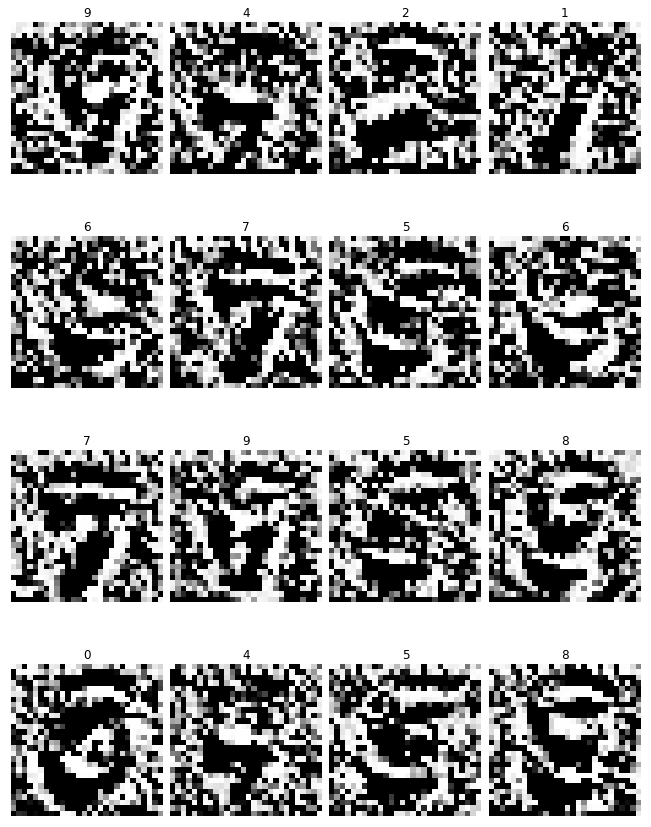

Iter: 100; D loss: 0.1032; G_loss: 0.05527; Predict-Loss: 80.15


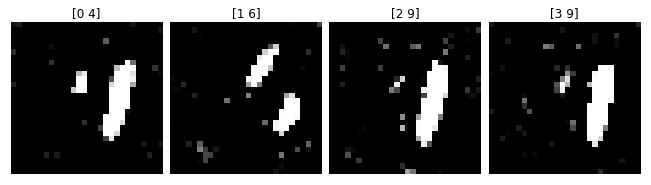

Iter: 200; D loss: 0.01913; G_loss: 0.06113; Predict-Loss: 79.8


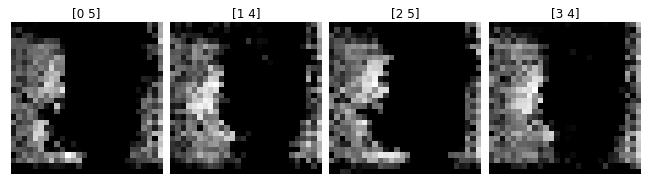

Iter: 300; D loss: 0.005788; G_loss: 0.08712; Predict-Loss: 79.91


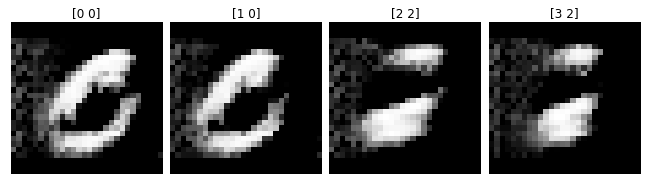

Iter: 400; D loss: 0.003224; G_loss: 0.09654; Predict-Loss: 79.72


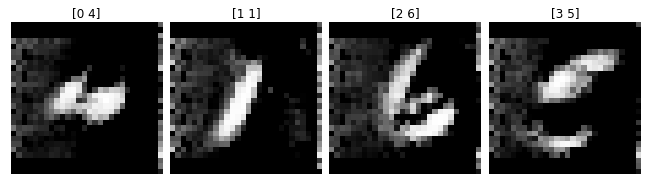

Iter: 500; D loss: 0.002062; G_loss: 0.09883; Predict-Loss: 79.12


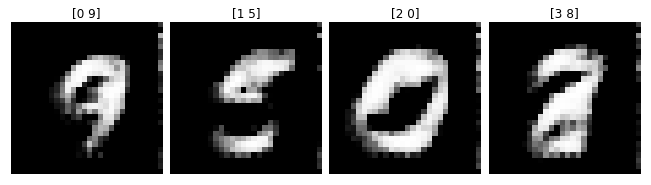

Iter: 600; D loss: 0.001463; G_loss: 0.1005; Predict-Loss: 79.1


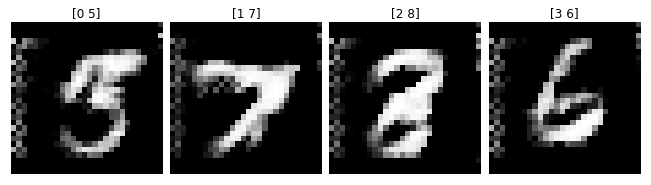

Iter: 700; D loss: 0.001029; G_loss: 0.0993; Predict-Loss: 79.04


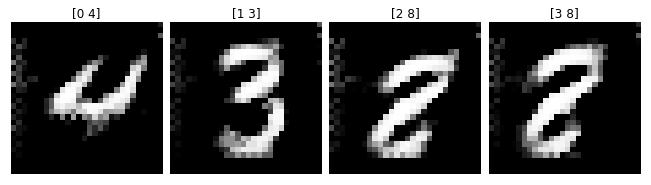

Iter: 800; D loss: 0.00186; G_loss: 0.09782; Predict-Loss: 79.35


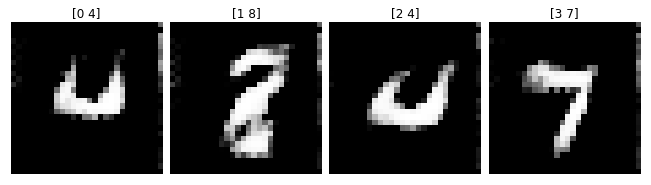

Iter: 900; D loss: 0.000354; G_loss: 0.09932; Predict-Loss: 79.27


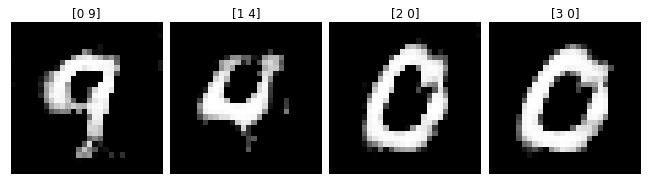

Iter: 1000; D loss: 0.0004245; G_loss: 0.0953; Predict-Loss: 80.12


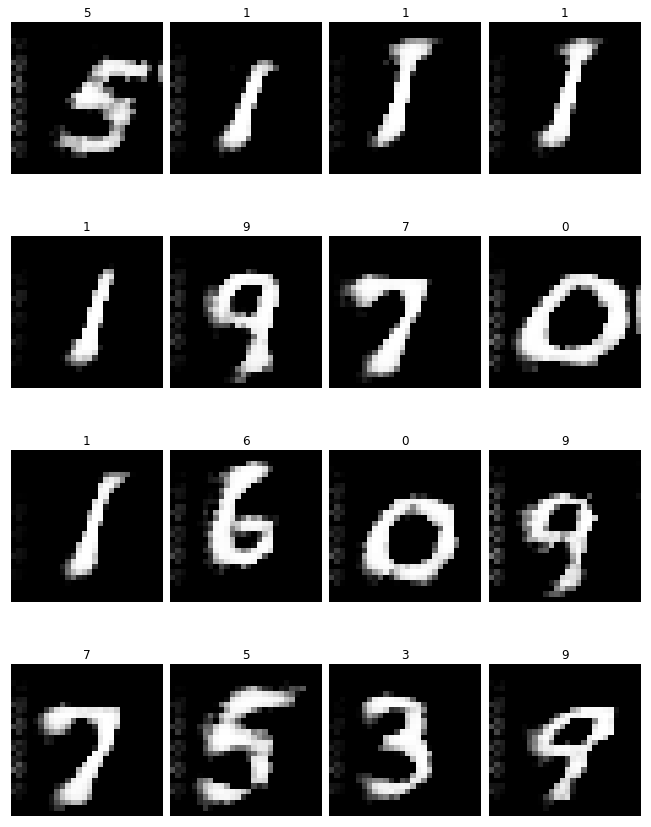

Iter: 1100; D loss: 0.0004946; G_loss: 0.08979; Predict-Loss: 79.15


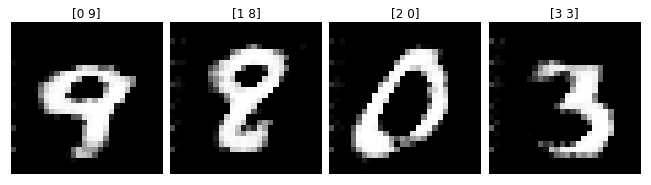

Iter: 1200; D loss: 0.0002361; G_loss: 0.08332; Predict-Loss: 78.93


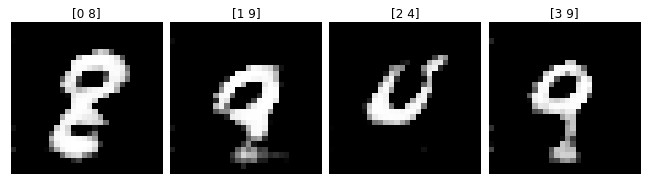

Iter: 1300; D loss: 0.0004821; G_loss: 0.07924; Predict-Loss: 78.35


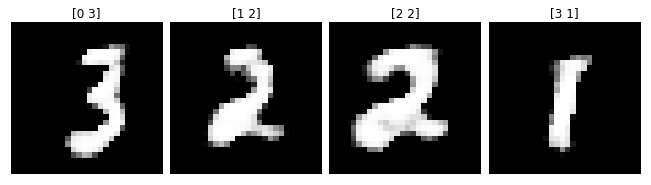

KeyboardInterrupt: 

In [14]:
i = 0
for it in range(30000):
    for q in range(5): #train discriminator
        (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
        Xdata, _ = mnist.train.next_batch(batch_size)
        mean_image = getMeanImage(batch_size,class_z) #get mean_image
        (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr,summary = sess.run(
            [D_solver, D_loss, merged_summary_op],
            feed_dict={X: Xdata, Z:z, Class_z:class_z, Mean_image:mean_image}
        )
        summary_writer.add_summary(summary, it+ q)
    (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
    mean_image = getMeanImage(batch_size,class_z) #get mean_image
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image}
    )
    _, P_loss_curr = sess.run(
    [P_solver, P_loss],
    feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image}
    ) 

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; Predict-Loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr,P_loss_curr))
        if it % 1000 == 0:
            (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
            mean_image = getMeanImage(batch_size,class_z) #get mean_image
            samples = sess.run(detail_image, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image})         
            samples[0] = np.reshape(samples[0], (batch_size,28,28))
            fig = plot(samples[0][:16], np.argwhere(class_z!=0)[:,1],4,4)
            plt.savefig('out-mnist/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
        else:
            (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
            mean_image = getMeanImage(batch_size,class_z) #get mean_image
            samples = sess.run(detail_image, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image}) 
            baseImages = sess.run(predictClass, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image})
            samples[0] = np.reshape(samples[0], (batch_size,28,28))
            fig = plot(samples[0][:4], np.argwhere(class_z!=0),1,4)
            plt.show()
            
plt.close(fig)